# Semantic Segmentation of Water using U-Net
# Part 2 - Train/Val/Test Split


Here I will divide my training data into training, validation, and test splits. The validation set will be used to evaluate different model hyperparameters before a final evaluation of model performance is done using the test set.

In [186]:
import numpy as np
import os
import pandas as pd
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

In [3]:
def get_lakes_with_masks(img_dir, mask_dir, return_masks=True, img_ext='jpg', mask_ext='png'):
    """ Determine lake images that have corresponding masks.
    
    Valid images are those that have a corresponding mask in
    mask_dir.
    
    """
    img_fns = sorted([fn for fn in os.listdir(img_dir) if fn.endswith(img_ext)]) 
    msk_fns = sorted([fn for fn in os.listdir(mask_dir) if fn.endswith(mask_ext)])
    
    img_fns = sorted(filter(lambda fn: f'{os.path.splitext(fn)[0]}_mask.png' in msk_fns,
                            img_fns)
                    )
    if return_masks:
        result = np.array(img_fns), np.array(msk_fns)
    else:
        result = np.array(img_fns)
    
    return result

In [4]:
valid_images, valid_masks = get_lakes_with_masks(nwpu_data_dir, nwpu_mask_dir)
print(len(valid_images))
print(valid_images[:10])

print(len(valid_masks))
print(valid_masks[:10])

400
['lake_001.jpg' 'lake_002.jpg' 'lake_003.jpg' 'lake_004.jpg'
 'lake_005.jpg' 'lake_006.jpg' 'lake_007.jpg' 'lake_008.jpg'
 'lake_009.jpg' 'lake_010.jpg']
400
['lake_001_mask.png' 'lake_002_mask.png' 'lake_003_mask.png'
 'lake_004_mask.png' 'lake_005_mask.png' 'lake_006_mask.png'
 'lake_007_mask.png' 'lake_008_mask.png' 'lake_009_mask.png'
 'lake_010_mask.png']


To load the images for training the model I am going to use the ImageDataGenerator class within Keras. This is useful for loading and batching the images and apply consistent augmentations.

The ImageDataGenerator has flow methods for processing data from several sources: a directory, a dataframe, or numpy arrays. The directory method assumes a certain directory structure so I'm going to use the dataframe method as it allows me to specify separate data and mask directories as well as just the images that have masks!

In [5]:
# Create DataFrames to store image paths
# by default flow_from_dataframe will read paths
# from a 'filename' column.
img_df = pd.DataFrame({'filename':valid_images})
msk_df = pd.DataFrame({'filename':valid_masks})

img_df.head()

,filename
0,lake_001.jpg
1,lake_002.jpg
2,lake_003.jpg
3,lake_004.jpg
4,lake_005.jpg


In [6]:
msk_df.head()

,filename
0,lake_001_mask.png
1,lake_002_mask.png
2,lake_003_mask.png
3,lake_004_mask.png
4,lake_005_mask.png


In the current state the dataframes contain all the training data. Before I go further however, I want to set aside a test set for final evaluation

In [9]:
test_size = 0.25 # 25%
test_samples = int(img_df.shape[0] * test_size)

# Test set indices
test_idxs = img_df.sample(test_samples, random_state=42).index

# The remaining row indices are used for the training set
train_idxs = img_df.index.difference(test_idxs)

In [10]:
train_img_df = img_df.iloc[train_idxs]
print(train_img_df)

         filename
1    lake_002.jpg
2    lake_003.jpg
4    lake_005.jpg
6    lake_007.jpg
7    lake_008.jpg
..            ...
392  lake_670.jpg
393  lake_678.jpg
397  lake_693.jpg
398  lake_694.jpg
399  lake_695.jpg

[300 rows x 1 columns]


In [11]:
train_msk_df = msk_df.iloc[train_idxs]
print(train_msk_df)

              filename
1    lake_002_mask.png
2    lake_003_mask.png
4    lake_005_mask.png
6    lake_007_mask.png
7    lake_008_mask.png
..                 ...
392  lake_670_mask.png
393  lake_678_mask.png
397  lake_693_mask.png
398  lake_694_mask.png
399  lake_695_mask.png

[300 rows x 1 columns]


In [12]:
test_img_df = img_df.iloc[test_idxs]
print(test_img_df)

         filename
209  lake_211.jpg
280  lake_283.jpg
33   lake_035.jpg
210  lake_212.jpg
93   lake_095.jpg
..            ...
314  lake_318.jpg
373  lake_615.jpg
380  lake_633.jpg
239  lake_241.jpg
75   lake_077.jpg

[100 rows x 1 columns]


In [13]:
test_msk_df = msk_df.iloc[test_idxs]
print(test_msk_df)

              filename
209  lake_211_mask.png
280  lake_283_mask.png
33   lake_035_mask.png
210  lake_212_mask.png
93   lake_095_mask.png
..                 ...
314  lake_318_mask.png
373  lake_615_mask.png
380  lake_633_mask.png
239  lake_241_mask.png
75   lake_077_mask.png

[100 rows x 1 columns]


In [14]:
# Save these test dataframes for later evaluation
with open('npwu_test_image_fns.pickle', 'wb') as f:
    pickle.dump(test_img_df, f)
    
with open('npwu_test_mask_fns.pickle', 'wb') as f:
    pickle.dump(test_msk_df, f)

With the test set put aside I can move on to creating the data generator. This has the option to further split the training data into training and validation sets. Note that the validation set is taken first so if there are 100 images in the validation set these will be the first 100 images in the dataframe used for the flow.

In [143]:
# Instantiate the data generator specifying a validation split.
datagen = ImageDataGenerator(validation_split=0.3)

In [156]:
# Create the train and val IMAGE flows
# Create a flow of the training data
train_img_gen = datagen.flow_from_dataframe(train_img_df,
                                        nwpu_data_dir,
                                        y_col=None, # None since the dataframe doesnt contain a label
                                        class_mode=None, # ^^^^
                                        shuffle=None, # Important - see text
                                        subset='training'
                                       )

# Create a flow of the validation data
val_img_gen = datagen.flow_from_dataframe(train_img_df,
                                        nwpu_data_dir,
                                        y_col=None,
                                        class_mode=None,
                                        shuffle=None,
                                        subset='validation'
                                       )

Found 210 validated image filenames.
Found 90 validated image filenames.


In [157]:
# Create the train and val MASK flows
# Create a flow of the training data
train_msk_gen = datagen.flow_from_dataframe(train_msk_df,
                                              nwpu_mask_dir,
                                              y_col=None,
                                              class_mode=None,
                                              shuffle=None,
                                              subset='training',
                                              color_mode='grayscale' # since the masks are single channel images
                                             )

# Create a flow of the validation data
val_msk_gen = datagen.flow_from_dataframe(train_msk_df,
                                            nwpu_mask_dir,
                                            y_col=None,
                                            class_mode=None,
                                            shuffle=None,
                                            subset='validation',
                                            color_mode='grayscale'
                                           )

Found 210 validated image filenames.
Found 90 validated image filenames.


Lets now check this works as expected!

In [152]:
# Now get a batch of training images and masks
train_img_batch = next(train_img_gen)
train_msk_batch = next(train_msk_gen)

print(train_img_batch.shape)
print(train_msk_batch.shape)

(32, 256, 256, 3)
(32, 256, 256, 1)


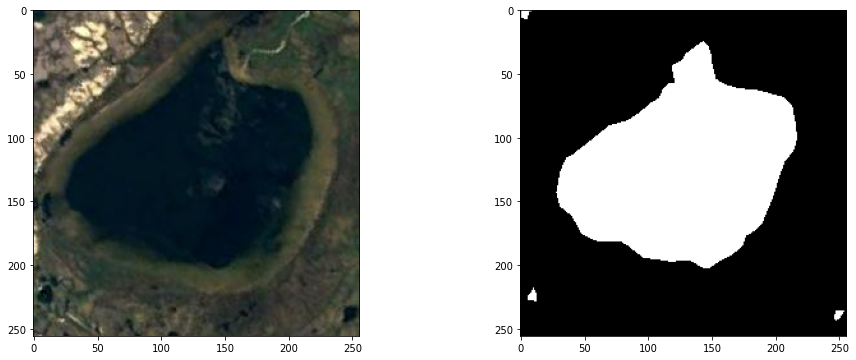

In [153]:
# Show the first training image and mask pair
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].imshow(train_img_batch[0,:,:].astype(np.int)) # Image values are 0 - 255 so must be int to plot RGB
ax[1].imshow(train_msk_batch[0,:,:,0], cmap='gray');

In [154]:
# Now get a batch of validation images and masks
val_img_batch = next(val_img_gen)
val_msk_batch = next(val_msk_gen)

print(val_img_batch.shape)
print(val_msk_batch.shape)

(32, 256, 256, 3)
(32, 256, 256, 1)


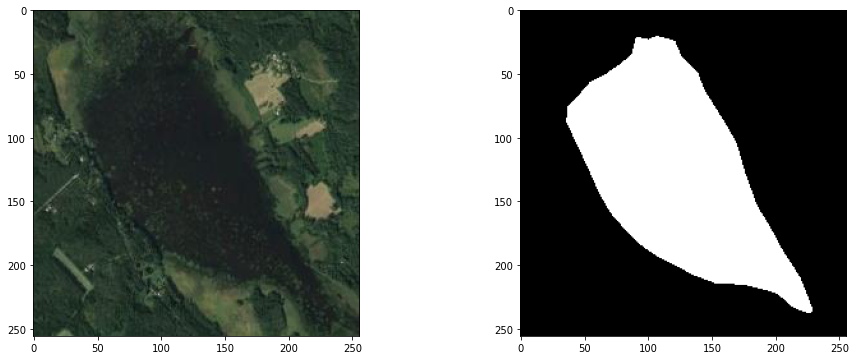

In [155]:
# Show the first validation image and mask pair
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].imshow(val_img_batch[0,:,:].astype(np.int))
ax[1].imshow(val_msk_batch[0,:,:,0], cmap='gray');

Note that I set the shuffle parameter to None. If this is true it will shuffle the images (after splitting into train and validation subsets) before returning a batch. This is fine for most circumstances but I need to also create image generators for the corresponding masks. Therefore to keep them aligned I will not shuffle the data in this process.

Because I'm not shuffling the data they are returned in the order they are in the dataframes. The validation split when instantiating the ImageDataGenerator is carried out without shuffliing so the row order in the dataframes is maintained.

Since I'm using the same configuration for the masks I can use the same ImageDataGenerator to create the image flows and the mask flows.

When using generators to fit models, the data should be provided via a single generator yielding X and y batches. To accomplish this, I simply create new training and validation generators that combine both the images (X) and the masks (y).

**IMPORTANT: Since the train/val img/msk generators have already been iterated during the above checks, they need to be reinstantiated to effectively "reset" them to the start of the data - do this now by rerunning the cells that set the `train_img_gen`, `val_img_gen`, `train_msk_gen` and `val_msk_gen`.**

In [158]:
# Now combine the image / mask generators
train_gen = (pair for pair in zip(train_img_gen, train_msk_gen))
val_gen = (pair for pair in zip(val_img_gen, val_msk_gen))

(32, 256, 256, 3)
(32, 256, 256, 1)


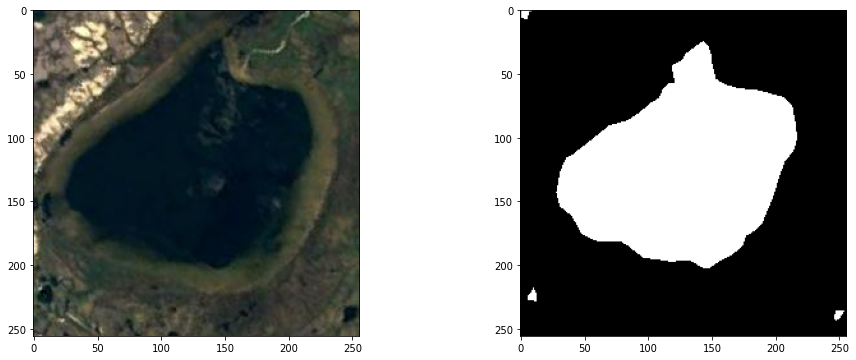

In [159]:
# Can now get image and mask batches in one call
train_img_batch, train_msk_batch = next(train_gen)
print(train_img_batch.shape)
print(train_msk_batch.shape)

# Check this matches the previous method with separate image and mask generators
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].imshow(train_img_batch[0,:,:].astype(np.int))
ax[1].imshow(train_msk_batch[0,:,:,0], cmap='gray');

If the above output does not match the previous check for the training images and masks, ensure the generators are reinstantiated prior to combining them.

By default the images are read as float32 data type. Note that this does not change the underlying values; the image still has values in the range 0 - 255

In [160]:
print(train_img_batch.dtype, train_img_batch.min(), train_img_batch.max())
print(train_msk_batch.dtype, train_msk_batch.min(), train_msk_batch.max())

float32 0.0 255.0
float32 0.0 255.0


The values still require some sort of scaling to transform them into the range 0 - 1. The ImageDataGenerator class provides a few useful parameters suited to this task. These must be provdied when instantiating the ImageDataGenerator. I will use the `rescale` parameter to scale the values by 1/255. I will explore other options later. 

For convenience and later use I'll create a function to handle this configuration. I'll also create a function to streamline the reading of image and mask filenames into dataframe and split off the training data.

In [177]:
# Function to load images with masks into dataframes
def make_dataframes_for_flow(img_dir, msk_dir, test_size=0.0,
                             random_state=None):
    """
    """
    valid_images, valid_masks = get_lakes_with_masks(img_dir, msk_dir)
    
    img_df = pd.DataFrame({'filename':valid_images})
    msk_df = pd.DataFrame({'filename':valid_masks})
    
    test_idxs = None
    if test_size == 0:
        return (img_df, msk_df)
        
    else:
        # Get train/test indices
        test_samples = int(img_df.shape[0] * test_size)
        test_idxs = img_df.sample(test_samples, random_state=random_state).index
        train_idxs = img_df.index.difference(test_idxs)
        
        # subset the images and mask dataframes
        train_img_df = img_df.iloc[train_idxs]
        train_msk_df = msk_df.iloc[train_idxs]
        
        test_img_df = img_df.iloc[test_idxs]
        test_msk_df = msk_df.iloc[test_idxs]
        
        return (train_img_df, train_msk_df, test_img_df, test_msk_df)

In [161]:
# Function to produce the train and val generators
def make_img_datagen(img_df, msk_df, img_dir, msk_dir, val_split=0.0,
                     batch_size=32, **kwargs):
    """Create image & mask generators
    
    Parameters
    ----------
    img_df: pd.DataFrame
    msk_df: pd.DataFrame
    img_dir: str
    msk_dir: str
    val_split: float, optional
    batch_size: int, optional
    **kwargs: dict
        Other keyword arguments that will be passed to the
        ImageDataGenerator
        
    Returns
    -------
    generator:
        If val_split is 0, only the training data generator
        is returned.
    tuple of generators:
        If val_split > 0, training and validation generators
        are returned.
    """
    # Instantiate the data generator specifying a validation split.
    datagen = ImageDataGenerator(validation_split=val_split, **kwargs)
    
    # Create the training data generators first
    train_img_gen = datagen.flow_from_dataframe(img_df,
                                                img_dir,
                                                y_col=None,
                                                class_mode=None,
                                                shuffle=None,
                                                subset='training',
                                                batch_size=batch_size
                                               )
    
    
    train_msk_gen = datagen.flow_from_dataframe(msk_df,
                                                msk_dir,
                                                y_col=None,
                                                class_mode=None,
                                                shuffle=None,
                                                subset='training',
                                                color_mode='grayscale',
                                                batch_size=batch_size
                                               )
    # Combine
    train_gen = (pair for pair in zip(train_img_gen, train_msk_gen))
    
    # If val_split is greater than 0, i.e. the data is actually split
    # create the validation image generators
    val_gen = None
    if val_split > 0:
        val_img_gen = datagen.flow_from_dataframe(img_df,
                                                  img_dir,
                                                  y_col=None,
                                                  class_mode=None,
                                                  shuffle=None,
                                                  subset='validation',
                                                  batch_size=batch_size
                                                 )



        # Create a flow of the validation data
        val_msk_gen = datagen.flow_from_dataframe(msk_df,
                                                  msk_dir,
                                                  y_col=None,
                                                  class_mode=None,
                                                  shuffle=None,
                                                  subset='validation',
                                                  color_mode='grayscale',
                                                  batch_size=batch_size
                                                 )
        
        val_gen = (pair for pair in zip(val_img_gen, val_msk_gen))
        
    if val_gen is None:
        return train_gen
    else:
        return (train_gen, val_gen)

In [182]:
# Generate the image and mask dataframes
# Can ignore the test set for now, or save to disk
# if not done already
train_img_df, train_msk_df, test_img_df, test_msk_df, = make_dataframes_for_flow(nwpu_data_dir,
                                                                                 nwpu_mask_dir,
                                                                                 test_size=0.25,
                                                                                 random_state=42
                                                                                )
test_img_fn = 'npwu_test_image_fns.pickle'
test_msk_fn = 'npwu_test_mask_fns.pickle'

for fn, data in zip([test_img_fn, test_msk_fn],[test_img_df, test_msk_df]):
    if not os.path.exists(fn):
        with open(fn, 'wb') as f:
            pickle.dump(data, f)

In [183]:
train_gen, val_gen = make_img_datagen(train_img_df, train_msk_df,
                                      nwpu_data_dir, nwpu_mask_dir,
                                      val_split=0.3, rescale=1/255)

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


In [184]:
# Check rescaling applied
train_img_batch, train_msk_batch = next(train_gen)
print(train_img_batch.shape)
print(train_msk_batch.shape)
print(train_img_batch.dtype, train_img_batch.min(), train_img_batch.max())
print(train_msk_batch.dtype, train_msk_batch.min(), train_msk_batch.max())


val_img_batch, val_msk_batch = next(val_gen)
print(val_img_batch.shape)
print(val_msk_batch.shape)
print(val_img_batch.dtype, val_img_batch.min(), val_img_batch.max())
print(val_msk_batch.dtype, val_msk_batch.min(), val_msk_batch.max())

(32, 256, 256, 3)
(32, 256, 256, 1)
float32 0.0 1.0
float32 0.0 1.0
(32, 256, 256, 3)
(32, 256, 256, 1)
float32 0.0 1.0
float32 0.0 1.0


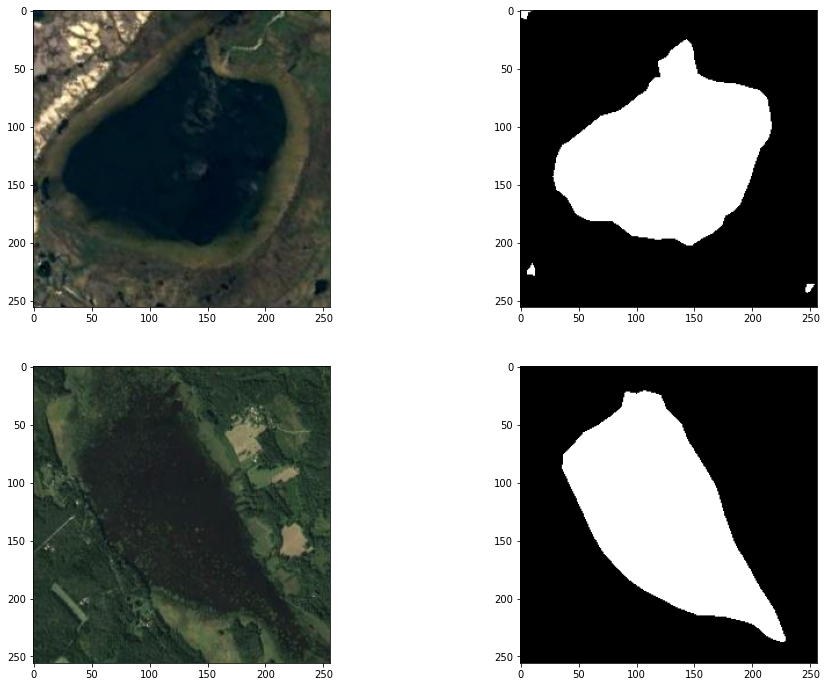

In [185]:
# Final visual check!

# Check this matches the previous method with separate image and mask generators
fig, axes = plt.subplots(2,2,figsize=(16,12))
axes[0][0].imshow(train_img_batch[0,:,:])
axes[0][1].imshow(train_msk_batch[0,:,:,0], cmap='gray');
axes[1][0].imshow(val_img_batch[0,:,:])
axes[1][1].imshow(val_msk_batch[0,:,:,0], cmap='gray');

I now have a fast, reproducible process for preparing my training, validation and test data.